<a href="https://colab.research.google.com/github/mpky/abrams_project/blob/master/final_project_image_classification_copy_5_20190413.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### M1 Abrams Image Classification

In this notebook, I will do the following:
  - Display a few sample images
  - Set up ImageDataGenerator to flow my image data into my model
  - Build the Convolutional Neural Network
  - Train the model over 200 epochs
  - Evaluate broader model performance
  - Observe how my model performs on four specific test images from combatant social media accounts. I.e. determine if my model can actually achieve what I have set out to achieve.

In [1]:
# The file I/O with Google Colab is a bit tricky, especially when interacting with Google Drive
# Need to mount Drive first to access files

from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
# Navigate into the proper project folder
%cd /content/gdrive/My\ Drive/Colab Notebooks
!pwd

/content/gdrive/My Drive/Colab Notebooks
/content/gdrive/My Drive/Colab Notebooks


In [3]:
%cd ./final_project

/content/gdrive/My Drive/Colab Notebooks/final_project


In [4]:
# Import a few libraries to be able to display sample images
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import seaborn as sns

from keras.models import load_model
from keras.preprocessing import image
from numpy.testing import assert_allclose
import numpy as np



Using TensorFlow backend.


In [0]:
# Create a function to display images

def display_image(image_filepath):
  image = cv2.imread(image_filepath)

  # cv2 reads images in in BGR, but matplotlib uses RGB
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  
  # Set a standard display size to deal with the different-sized images
  fig = plt.figure(figsize=(12,10))
  ax = fig.add_subplot(111)
  ax.grid(False)
  ax.imshow(image)
  return plt.show()


In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
# Set the parameters for adding "noise" to the images
image_gen_aug = ImageDataGenerator(rotation_range=20, # slight rotation
                               width_shift_range=0.1, # randomly resizing images
                               height_shift_range=0.1,
                               rescale=1/255, 
                               shear_range=0.2, # crops out parts of the image
                               zoom_range=0.2,
                               horizontal_flip=True, # flip images along the horizontal axis
                               fill_mode='nearest'
                               )

image_gen_no_aug = ImageDataGenerator()

In [8]:
# Now generate many images from the directory
image_gen_aug.flow_from_directory('abrams_not_abrams/train')

Found 1489 images belonging to 2 classes.


In [0]:
# Build the Convolutional Neural Network
from keras.models import Sequential
from keras.layers import Activation,Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

In [0]:
# Set image shape
# Larger values were beginning to take much more time to fit
input_shape = (150,150,3)

In [11]:
# Build model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Dropout will help prevent overfitting and prevent any one node from dominating a prediction

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# Set batch size
batch_size = 16

# Assign train_image_gen to input into .fit_generator
train_image_gen = image_gen_aug.flow_from_directory('abrams_not_abrams/train',
                                                   target_size=input_shape[:2],
                                                   batch_size=batch_size,
                                                   class_mode='binary')

Found 1489 images belonging to 2 classes.


In [13]:
# test_image_gen will give us validation accuracy and loss on each epoch to see if the model is actually learning 
# or just overfitting on the training data
test_image_gen = image_gen_no_aug.flow_from_directory('abrams_not_abrams/test',
                                                   target_size=input_shape[:2],
                                                   batch_size=batch_size,
                                                   class_mode='binary')

Found 470 images belonging to 2 classes.


In [26]:
# Fit the model and assign to the results variable
# At ~30 seconds per epoch for 500 epochs, this will take some time to train

filepath = "cnn-20190413-500epochs.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

results = model.fit_generator(train_image_gen,epochs=500,steps_per_epoch=32,
                              validation_data=test_image_gen,validation_steps=10,
                              callbacks=callbacks_list)

Epoch 1/500
32/32 [==============================] - 12s 374ms/step - loss: 0.4498 - acc: 0.7930 - val_loss: 2.2635 - val_acc: 0.8375

Epoch 00001: loss improved from inf to 0.44981, saving model to cnn-20190413-500epochs.h5
Epoch 2/500
32/32 [==============================] - 10s 314ms/step - loss: 0.4328 - acc: 0.7928 - val_loss: 1.6474 - val_acc: 0.8667

Epoch 00002: loss improved from 0.44981 to 0.44412, saving model to cnn-20190413-500epochs.h5
Epoch 3/500
32/32 [==============================] - 12s 367ms/step - loss: 0.4239 - acc: 0.7969 - val_loss: 2.4824 - val_acc: 0.8187

Epoch 00003: loss improved from 0.44412 to 0.42390, saving model to cnn-20190413-500epochs.h5
Epoch 4/500
 3/32 [=>............................] - ETA: 12s - loss: 0.5016 - acc: 0.6667

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


32/32 [==============================] - 11s 354ms/step - loss: 0.4434 - acc: 0.8027 - val_loss: 1.8378 - val_acc: 0.8812

Epoch 00004: loss did not improve from 0.42390
Epoch 5/500
32/32 [==============================] - 11s 340ms/step - loss: 0.4428 - acc: 0.7839 - val_loss: 3.2790 - val_acc: 0.7733

Epoch 00005: loss did not improve from 0.42390
Epoch 6/500
32/32 [==============================] - 11s 341ms/step - loss: 0.4530 - acc: 0.7793 - val_loss: 2.3316 - val_acc: 0.8313

Epoch 00006: loss did not improve from 0.42390
Epoch 7/500
32/32 [==============================] - 11s 354ms/step - loss: 0.4378 - acc: 0.7754 - val_loss: 2.1553 - val_acc: 0.8625

Epoch 00007: loss did not improve from 0.42390
Epoch 8/500
32/32 [==============================] - 11s 343ms/step - loss: 0.5156 - acc: 0.7741 - val_loss: 2.1491 - val_acc: 0.8667

Epoch 00008: loss did not improve from 0.42390
Epoch 9/500
32/32 [==============================] - 11s 343ms/step - loss: 0.4335 - acc: 0.7949 - val

In [25]:
# load the model
new_model = load_model("cnn-20190413-20epochs.h5")
# assert_allclose(model.predict(x_train),
#                 new_model.predict(x_train),
#                 1e-5)

# fit the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit_generator(train_image_gen,epochs=5,steps_per_epoch=32,
                              validation_data=test_image_gen,validation_steps=10,
                              callbacks=callbacks_list)

Epoch 1/5
32/32 [==============================] - 12s 379ms/step - loss: 0.4713 - acc: 0.7644 - val_loss: 2.1030 - val_acc: 0.8600

Epoch 00001: loss improved from inf to 0.46448, saving model to cnn-20190413-20epochs.h5


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch 2/5
32/32 [==============================] - 10s 326ms/step - loss: 0.3932 - acc: 0.8145 - val_loss: 2.5838 - val_acc: 0.8125

Epoch 00002: loss improved from 0.46448 to 0.39319, saving model to cnn-20190413-20epochs.h5
Epoch 3/5
32/32 [==============================] - 12s 371ms/step - loss: 0.4769 - acc: 0.7480 - val_loss: 2.5207 - val_acc: 0.8125

Epoch 00003: loss did not improve from 0.39319
Epoch 4/5
32/32 [==============================] - 10s 323ms/step - loss: 0.4586 - acc: 0.7928 - val_loss: 1.9620 - val_acc: 0.8667

Epoch 00004: loss did not improve from 0.39319
Epoch 5/5
32/32 [==============================] - 11s 337ms/step - loss: 0.4290 - acc: 0.7773 - val_loss: 2.3170 - val_acc: 0.8063

Epoch 00005: loss did not improve from 0.39319


In [14]:
# Load the saved model
loaded_model = load_model('cnn-20190413-500epochs.h5')

Instructions for updating:
Use tf.cast instead.


In [17]:
# Use .evaluate_generator() and test_image_gen to determine how the model performs on the testing data
filenames = test_image_gen.filenames
# Have to set steps to the number of files in the test folder
nb_samples = len(filenames)
loaded_model.evaluate_generator(test_image_gen,verbose=1,steps=nb_samples)

 25/470 [>.............................] - ETA: 1:15

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


470/470 [==============================] - 80s 170ms/step


[2.699860864392553, 0.8324728259735781]

In [18]:
# First, get y_pred

y_pred = []
for file in test_image_gen.filenames:
  # NN will expect images in 150x150 so have to resize
  abrams_img = image.load_img('abrams_not_abrams/test/' + file,target_size=(150,150))
  abrams_img = image.img_to_array(abrams_img) # convert to array
  abrams_img = np.expand_dims(abrams_img, axis=0) # expand dimensions to fit NN
  
  abrams_img = abrams_img/255 # scale it for the model
  prediction = loaded_model.predict_classes(abrams_img)

  y_pred.append(prediction[0][0])
  

print(y_pred)
# Confirm it's the right length
print(len(y_pred))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [19]:
# Next, get y_true

abrams_count = 0
not_abrams_count = 0
for file in filenames:
  if file.split('/')[0] == 'abrams':
    abrams_count += 1
  else:
    not_abrams_count += 1

# Print the counts of each class so we know how to fill our y_true array
print(abrams_count, not_abrams_count)

y_true = np.array([0] * 389 + [1] * 81)
y_true

389 81


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
# Get statistics with sklearn's various functions
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, accuracy_score

In [21]:
print(confusion_matrix(y_true,y_pred))
print('Accuracy:')
print(accuracy_score(y_true,y_pred),'\n')
# Will use f1 score as there's a fair amount of class imbalance
print('F1 Score:')
print(f1_score(y_true,y_pred))

[[347  42]
 [ 22  59]]
Accuracy:
0.8638297872340426 

F1 Score:
0.6483516483516484


The model has more Type I errors or false positives than it does Type II errors (false negatives). I would prefer the opposite as it would be better for it to predict too many M1 Abrams than for the model to miss images that actually do contain M1 Abrams. This is something to address in my next steps.

Now I want to visually inspect how it performs on a sampling of images.

In [0]:
# Make a function to predict specific images and provide confidence of the prediction

def abrams_predict(image_filepath, model):
  abrams_img = image.load_img(image_filepath,target_size=(150,150))
  abrams_img = image.img_to_array(abrams_img)
  
  # Need to change dimensions so it's a batch of 1 image
  abrams_img = np.expand_dims(abrams_img, axis=0)
  # Re-scale the pixel values
  abrams_img = abrams_img/255
  print('Class prediction:')
  print(model.predict_classes(abrams_img))
  print('Prediction %:')
  print(model.predict(abrams_img))

In [23]:
# Here's how ImageDataGenerator has read in and assigned the classes
print(test_image_gen.class_indices)

{'abrams': 0, 'not_abrams': 1}


Class prediction:
[[1]]
Prediction %:
[[0.97613066]]


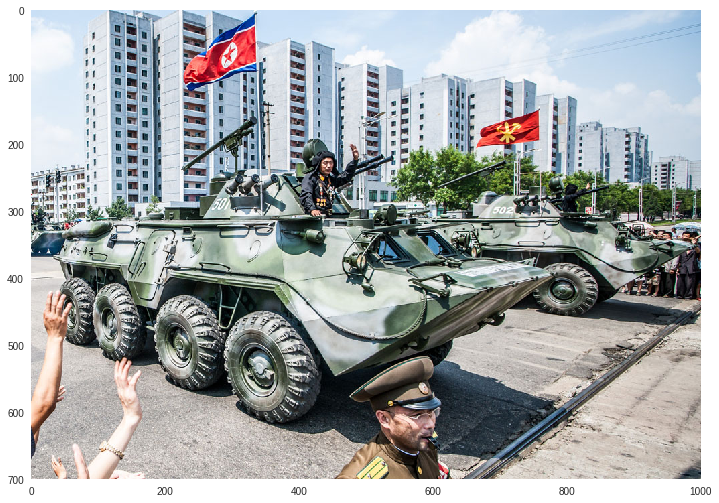

In [24]:
abrams_predict('abrams_not_abrams/test/not_abrams/8wh_m2010b.jpg',loaded_model)
display_image('abrams_not_abrams/test/not_abrams/8wh_m2010b.jpg')

Correctly predicted these APCs as "not Abrams" and did so with 92% confidence.

Class prediction:
[[1]]
Prediction %:
[[0.90687734]]


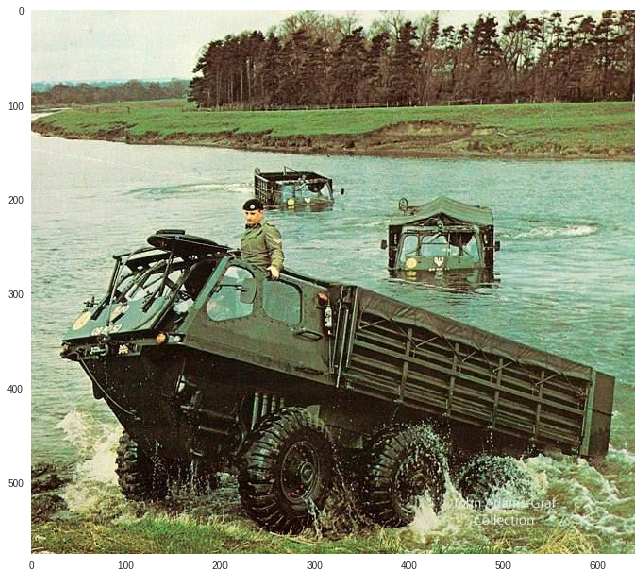

In [25]:
abrams_predict('abrams_not_abrams/test/not_abrams/007b904c4e78daaebdd4568278060e89__british_tanks_british_army.jpg',loaded_model)
display_image('abrams_not_abrams/test/not_abrams/007b904c4e78daaebdd4568278060e89__british_tanks_british_army.jpg')

The model was even more confident these trucks were not M1 Abrams tanks.

Class prediction:
[[0]]
Prediction %:
[[2.2281652e-14]]


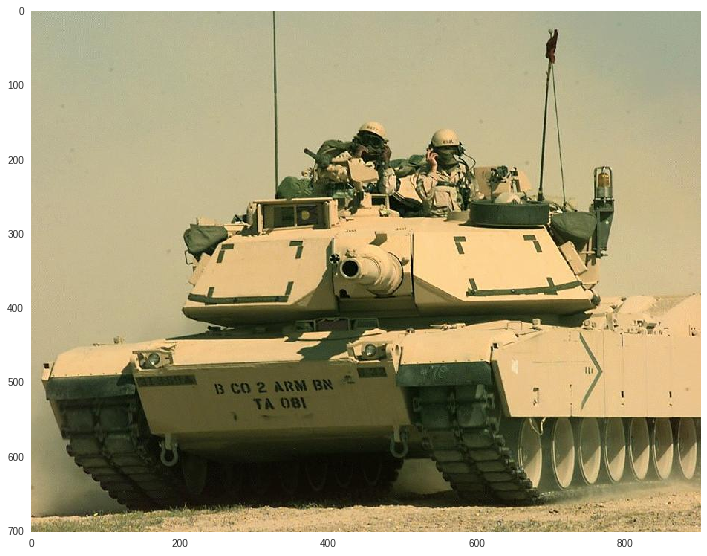

In [26]:
abrams_predict('abrams_not_abrams/test/abrams/m1a1_tankinmo 2.jpg',loaded_model)
display_image('abrams_not_abrams/test/abrams/m1a1_tankinmo 2.jpg')

For this image of an M1 Abrams, the model was extremely confident (>99.99999%) that this was an image of an M1 Abrams tank.

Class prediction:
[[0]]
Prediction %:
[[4.126071e-08]]


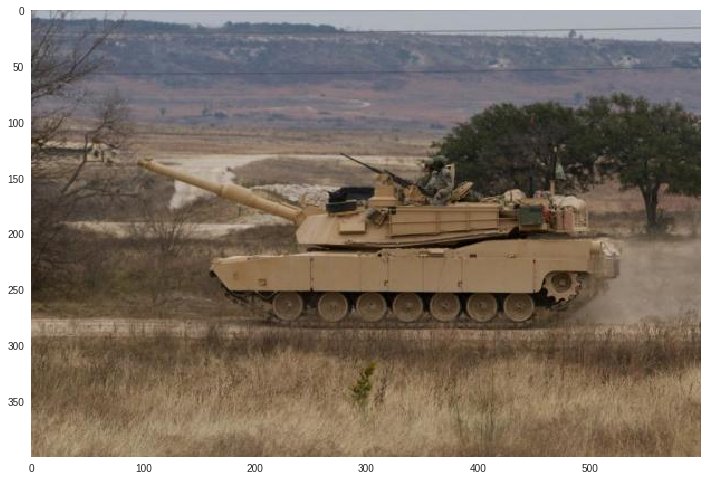

In [27]:
abrams_predict('abrams_not_abrams/test/abrams/US_Army_selects_General_Dynamics_for_Abrams_tank_production (1).jpg',loaded_model)
display_image('abrams_not_abrams/test/abrams/US_Army_selects_General_Dynamics_for_Abrams_tank_production (1).jpg')

It was also very confident this was an M1 Abrams tank, despite it being from the side. It is possible the model has picked up on the number of wheels or the distinct shape of the turret.

Class prediction:
[[0]]
Prediction %:
[[0.43548757]]


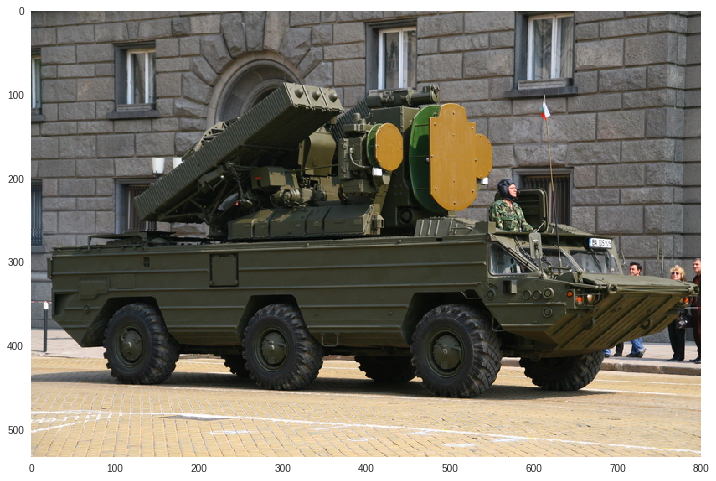

In [28]:
abrams_predict('abrams_not_abrams/test/not_abrams/Bulgarian_SA_8.jpg',loaded_model)
display_image('abrams_not_abrams/test/not_abrams/Bulgarian_SA_8.jpg')

The model got this one correct, but only barely.

The real images I care about are those from a few social media accounts of Iraq militia groups. This first one is from the video I mentioned as the genesis for this project. The group was showing off its equipment in a military parade and quickly panned over this M1 Abrams on the back of one of their trucks.

Class prediction:
[[0]]
Prediction %:
[[7.927976e-07]]


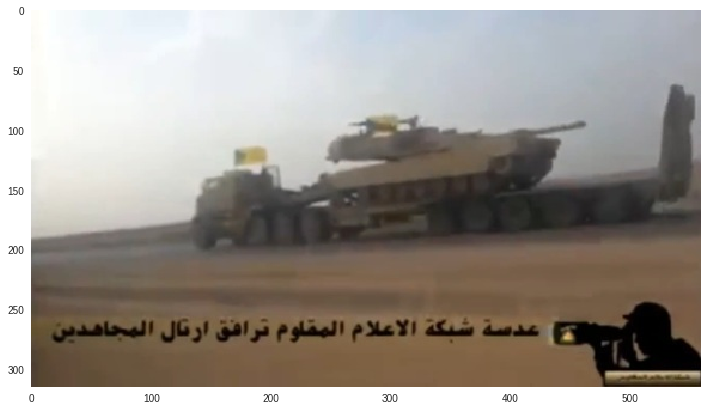

In [29]:
abrams_predict('abrams_not_abrams/KH_abrams_1.jpg',loaded_model)
display_image('abrams_not_abrams/KH_abrams_1.jpg')

The model is 99.98% confident this picture has an M1 Abrams in it.

A second image from a different militia group.

Class prediction:
[[0]]
Prediction %:
[[2.6498864e-07]]


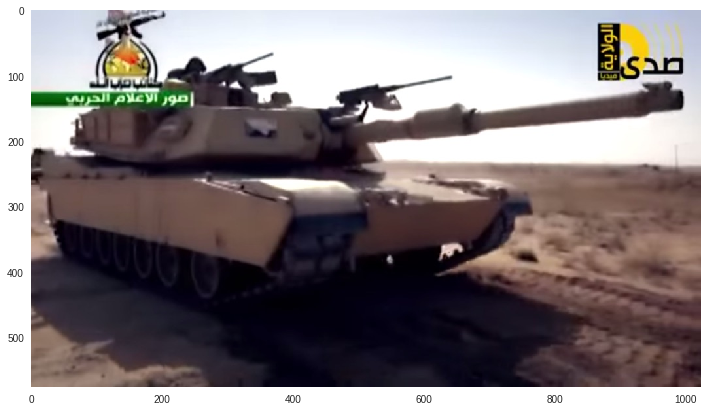

In [30]:
abrams_predict('abrams_not_abrams/KH_abrams_2_jpg.jpg',loaded_model)
display_image('abrams_not_abrams/KH_abrams_2_jpg.jpg')

Class prediction:
[[0]]
Prediction %:
[[0.16675346]]


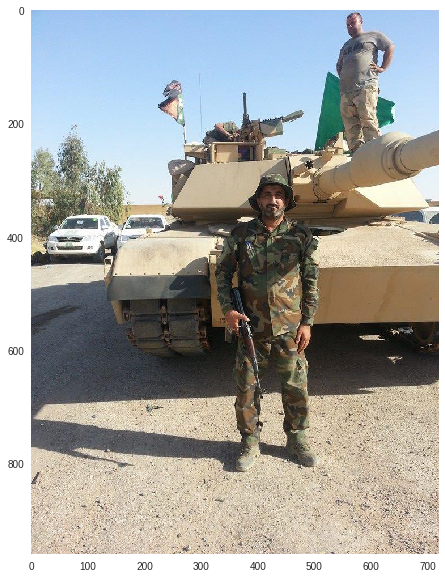

In [31]:
abrams_predict('abrams_not_abrams/badr_abrams_1.jpg',loaded_model)
display_image('abrams_not_abrams/badr_abrams_1.jpg')

Here the tank is partially occluded by the man, but the model is still able to correctly predict the M1 Abrams with a high degree of confidence.

Class prediction:
[[1]]
Prediction %:
[[0.9599938]]


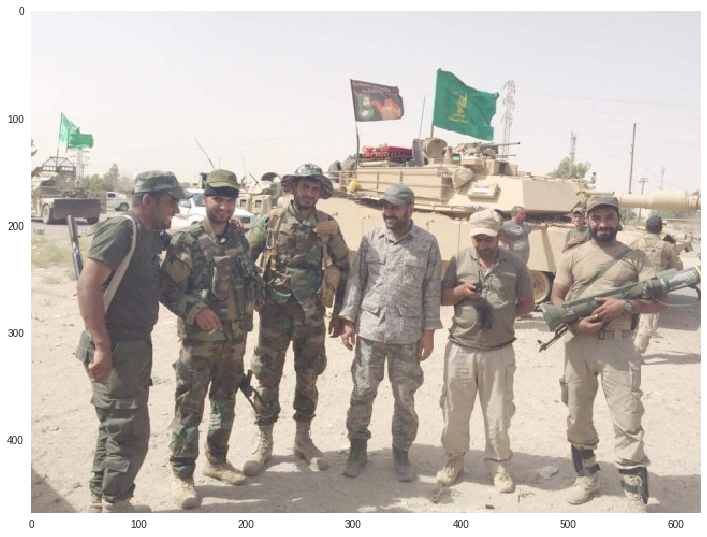

In [32]:
abrams_predict('abrams_not_abrams/badr_abrams_2.jpg',loaded_model)
display_image('abrams_not_abrams/badr_abrams_2.jpg')

This last image is definitely the hardest as only the top of the tank is really visible. Understandably, the confidence is a bit lower, but I am very pleased to see the model correctly predicted there to be an M1 Abrams in this image from the Badr Brigade.